# Redes Generativas Adversariais (GANs) com Keras

Neste exercício, vamos construir uma GAN para **gerar** os dígitos do MNIST.


## Imports

Primeiro, vamos importar alguns pré-requisitos:

In [1]:
from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

# Arquitetura

GANs são formadas por duas redes: o **gerador** e o **discriminador**. 
A solução proposta nessa prática é a original, proposta em 2014 por Goodfellow et al. para as GANs, utilizando apenas camadas densas para compor as redes. Com o passar do tempo essas arquiteturas evoluíram (veja a Tarefa 4!!) porém a ideia básica continua a mesma 

O discriminador é uma rede neural para classificação, assim como outras que vimos durante o curso. Ela classificará as imagens de entrada como **reais** ou **falsas**. Essa informação é utilizada no treinamento de ambas as redes.

Sumarizando, o discriminador:
  1. Recebe batches de imagens reais, ou batches de imagens falsas. (Elas precisam ter o mesmo tamanho!)
  2. Retorna um score de classificação, e pode retropropagar o erro para as duas redes para treinamento.

O gerador é um **decodificador** que aprende a manipular um vetor de entrada (usamos um ruído aleatório) de forma que ele seja transformado em uma imagem de uma distribuição de interesse (no nosso caso, dígitos do MNIST). Variando o ruído de entrada, a imagem gerada final também é alterada. 

A arquitetura é uma parte bastante importante de uma GAN, pois através dela **controlamos as dimensões das imagens geradas.** Caso quiséssemos gerar imagens maiores, ou com mais camadas (RGB), precisamos aumentar o número de neurônios na última camada.

Note também como usamos *tanh* como função de ativação da última camada do gerador. Qual o motivo para isso? 

In [2]:
def build_generator(latent_dim, img_shape):
  model = Sequential()

  model.add(layers.Dense(256, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(1024))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
  model.add(layers.Reshape(img_shape))

  #model.summary()

  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Flatten(input_shape=img_shape))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  #model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def sample_images(iter, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Re-escale as imagens para [0, 1] para plotar.
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

# Treinamento

Como estamos lidando com duas redes independentes, mas que são treinadas de forma conjunta, precisamos coordenar essas operações no nosso modelo:

   1. Primeiro, **apenas** o discriminador é treinado de acordo com o erro de classificação.
   2. Depois, em um próximo estágio, **apenas** o gerador é treinado de acordo com o erro de classificação do discriminador. **Note que o gerador nunca "vê" os dados reais**.



In [3]:
img_shape = (28, 28, 1)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 1)                 533505    
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         1493520   
_________________________________________________________________
model (Model)                (None, 1)                 533505    
Total params: 2,027,025
Trainable para

## Pré-processamento dos dados para treinamento:

Nós escalamos as entradas para estarem no intervalo [-1-1] ao invés de [0-255]. Por isso usamos *tanh* como função de ativação da última camada do gerador. Lembre-se que *tanh* limita os dados para estarem neste intervalo.

Além disso, precisamos criar os labels para o treinamento da nossa rede. 
Imagens reais recebem o valor `1`, enquanto imagens geradas (sintéticas) recebem o valor `0`.

In [4]:
batch_size=64

# Carregue o dataset
(X_train, _), (_, _) = mnist.load_data()

# Re-escale de -1 a 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

## Rotina de treinamento:

### Discriminador
1. Treine o discriminador em um batch de imagens reais -> (imgs, valid)
2. Treine o discriminador em um batch de imagens sintéticas -> (gen_imgs, fake)
3. Combine as duas loss, tirando a média de cada avaliação.

### Gerador
1. Com os pesos do discriminador congelados, treine o gerador para tentar fazer com que o discriminador retorne `1` (real) para as imagens sintéticas. -> (gen_imgs(noise), valid)

### Verifique a evolução das imagens geradas durante o treinamento!


0 [D loss: 0.617925, acc.: 57.81%] [G loss: 0.702907]


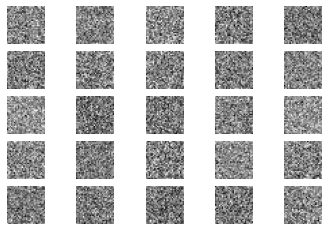

200 [D loss: 0.279501, acc.: 87.50%] [G loss: 2.812832]


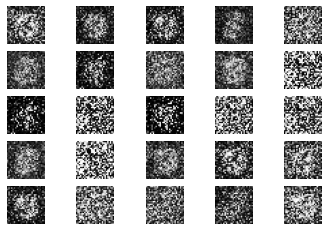

400 [D loss: 0.654247, acc.: 49.22%] [G loss: 0.675710]


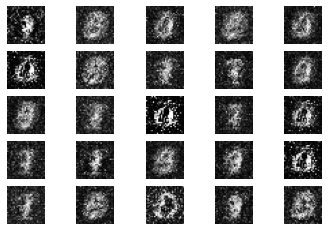

600 [D loss: 0.621236, acc.: 58.59%] [G loss: 0.771752]


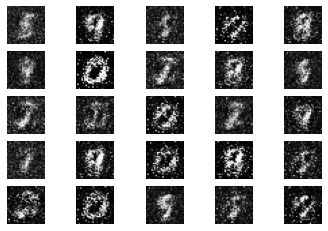

800 [D loss: 0.644751, acc.: 60.94%] [G loss: 0.826356]


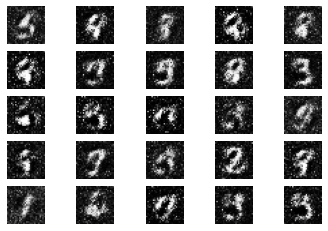

1000 [D loss: 0.610312, acc.: 66.41%] [G loss: 0.920648]


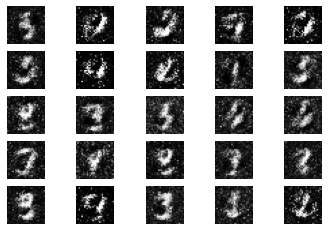

1200 [D loss: 0.588629, acc.: 69.53%] [G loss: 0.978137]


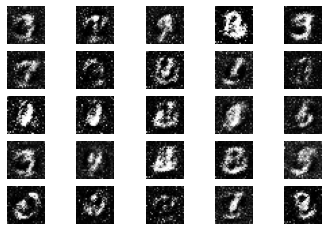

1400 [D loss: 0.542818, acc.: 81.25%] [G loss: 0.963884]


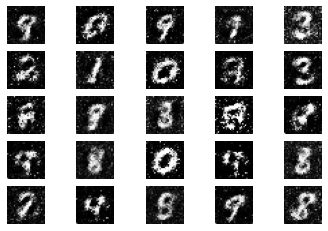

1600 [D loss: 0.548357, acc.: 75.78%] [G loss: 0.927058]


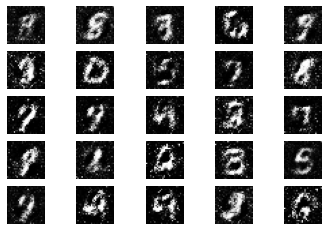

1800 [D loss: 0.621773, acc.: 66.41%] [G loss: 0.937365]


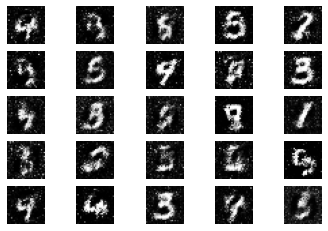

2000 [D loss: 0.545612, acc.: 75.00%] [G loss: 0.887500]


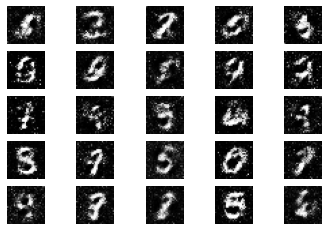

2200 [D loss: 0.557651, acc.: 73.44%] [G loss: 0.970592]


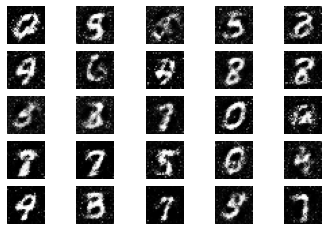

2400 [D loss: 0.599345, acc.: 67.19%] [G loss: 0.973339]


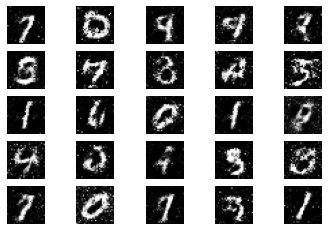

2600 [D loss: 0.611863, acc.: 64.06%] [G loss: 0.959671]


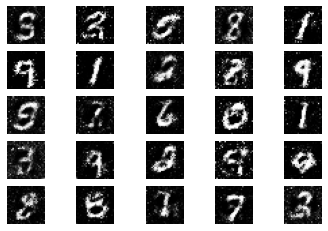

2800 [D loss: 0.603225, acc.: 67.97%] [G loss: 1.045281]


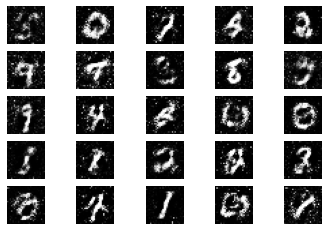

3000 [D loss: 0.597199, acc.: 71.09%] [G loss: 0.937981]


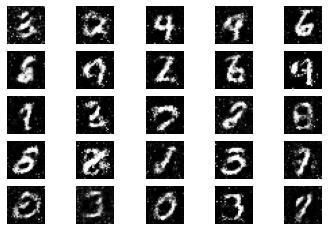

3200 [D loss: 0.624236, acc.: 64.84%] [G loss: 0.940799]


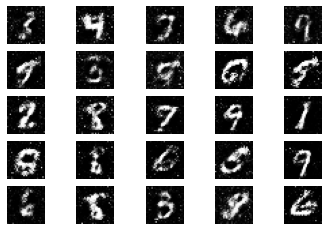

3400 [D loss: 0.620626, acc.: 67.19%] [G loss: 0.869274]


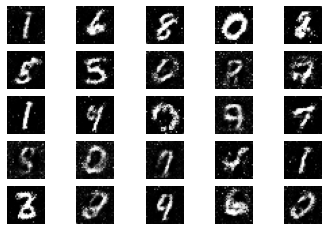

3600 [D loss: 0.583428, acc.: 72.66%] [G loss: 0.925796]


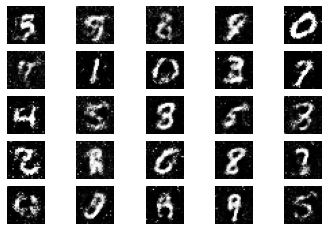

3800 [D loss: 0.589347, acc.: 70.31%] [G loss: 0.931897]


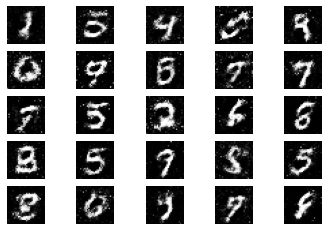

4000 [D loss: 0.619779, acc.: 65.62%] [G loss: 0.946360]


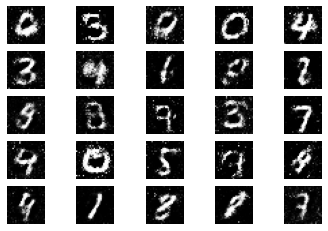

4200 [D loss: 0.630357, acc.: 63.28%] [G loss: 0.884263]


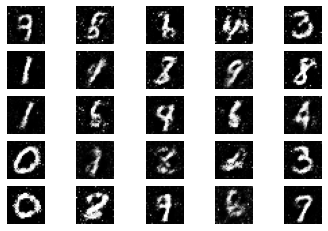

4400 [D loss: 0.677273, acc.: 54.69%] [G loss: 0.881560]


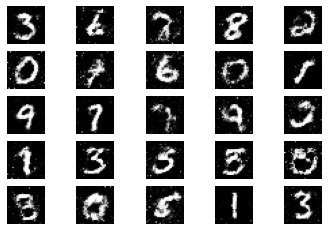

4600 [D loss: 0.674411, acc.: 57.81%] [G loss: 0.927613]


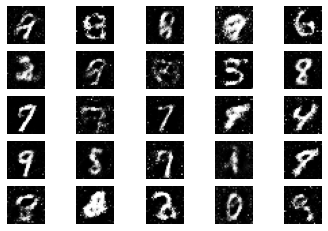

4800 [D loss: 0.611329, acc.: 69.53%] [G loss: 0.906986]


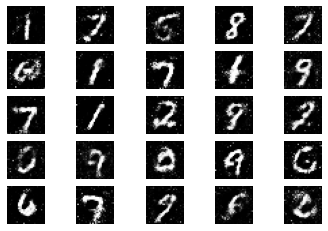

In [5]:
iterations=5000
sample_interval=200

for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)
